## 1. 定义算法

DRQN 是在 DQN 的基础上进行的改进，它只将网络中隐层改成了LSTM网络，其他的配置基本不变。引入了LSTM，可以处理在智能体训练过程中的部分可观的情况，从而可以学习到更加优秀的策略。

### 1.1、 定义模型

这里的 DRQN 的模型将 DQN 中三层 MLP 中间的隐藏层改成了 LSTM 网络。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class LSTM(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim = 64):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.l1 = nn.Linear(n_states, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True) # 
        self.l2 = nn.Linear(hidden_dim, n_actions)

    def forward(self, x, h, c):
        x = F.relu(self.l1(x))
        x, (h, c) = self.lstm(x, (h, c))
        x = self.l2(x)
        return x, h, c

    def sample_action(self, state, h, c, epsilon):
        output = self.forward(state, h,c)

        if random.random() < epsilon:
            return random.randint(0,1), output[1], output[2]
        else:
            return output[0].argmax().item(), output[1] , output[2]

    def init_hidden_state(self, batch_size, training=None):
        if training is True:
            return torch.zeros([1, batch_size, self.hidden_dim]), torch.zeros([1, batch_size, self.hidden_dim])
        else:
            return torch.zeros([1, 1, self.hidden_dim]), torch.zeros([1, 1, self.hidden_dim])
        

### 1.2、定义经验回放

这里的经验回放和 DQN 中不一样， DRQN 的更新方式主要有两种：（1）序列更新。从经验回放内存中随机选取回合，从开始一直学习到结束。（2）随机更新。从经验回放内存中随机选取回合，从回合中的随机点开始，并且仅仅学习一定的时间步长。其中的 RNN 每次更新时归零。

所以这里的经验回放要比 DQN 中的经验回放对一个回合上的维度。此外，还需要和 DQN 中一样的经验回放来记录一个回合中的所有数据。

In [2]:
import numpy as np
import copy
from collections import deque


class GRUMemory:
    def __init__(self, capacity: int, max_epi_num:int, max_epi_len:int, lookup_size = 2) -> None:
        self.capacity = capacity # capacity of memory
        self.lookup_size = lookup_size # lookup size for sequential sampling
        self.buffer = deque(maxlen=max_epi_num)
        self.lookup_buffer = []
        self.max_epi_len = max_epi_len
    def push(self, episode):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(episode)
    def sample(self, batch_size: int, sequential: bool = False):

        sampled_buffer = []
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            idx = np.random.randint(0, len(self.buffer))
            sampled_buffer.append(self.buffer[idx].sample(len(self.buffer[idx])))
            return sampled_buffer # zip(*sampled_buffer)
        else:
            sampled_episodes = random.sample(self.buffer, batch_size)
            min_step = self.max_epi_len
            for episode in sampled_episodes:
                min_step = min(min_step, len(episode))

            for episode in sampled_episodes:
                if min_step > self.lookup_size: # sample buffer with lookup_step size
                    idx = np.random.randint(0, len(episode)-self.lookup_size+1)
                    sample = copy.deepcopy(episode.buffer[idx:idx+self.lookup_size])
                    sampled_buffer.append(sample)
                else:
                    idx = np.random.randint(0, len(episode)-min_step+1) # sample buffer with minstep size
                    sample = copy.deepcopy(episode.buffer[idx:idx+min_step])
                    sampled_buffer.append(sample)                            
            return sampled_buffer
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)


class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = [] # 缓冲区
        self.position = 0 
        
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = transitions
        self.position = (self.position + 1) % self.capacity 

    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 1.3、模型算法定义

这里根据前面的 LSTM 搭建智能体agent，其中的动作采样和DQN基本一致，模型更新即如从所述有序列更新和随机更新两种更新方式。

In [3]:
class DRQN:
    def __init__(self, model, memory, cfg) -> None:
        self.sample_count = 0
        self.device = torch.device(cfg.device)
        self.gamma = cfg.gamma  

        self.policy_net = model.to(self.device)
        self.target_net = model.to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=cfg.lr)

        self.memory = memory
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay

        self.epsilon = cfg.epsilon_start
        self.batch_size = cfg.batch_size
        self.min_epi_num = cfg.min_epi_num
        self.hidden_dim = cfg.hidden_dim

        self.update_flag = False
        self.target_update = cfg.target_update

    def sample_action(self, state, h, c):
        
        self.sample_count += 1
        # epsilon must decay(linear,exponential and etc.) for balancing exploration and exploitation
        # self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
        #     math.exp(-1. * self.sample_count / self.epsilon_decay)

        action, h, c = self.policy_net.sample_action(torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(self.device), 
                                              h.to(self.device), c.to(self.device), self.epsilon) 

        return action, h, c
    @torch.no_grad()
    def predict_action(self, state, h, c):
        output = self.policy_net.forward(torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(self.device), \
            h.to(self.device), c.to(self.device))
        return output[0].argmax().item(), output[1] , output[2] 

    def update(self):
        if len(self.memory) < self.min_epi_num :
            return
        else:
            if not self.update_flag:
                print("Begin to update!")
                self.update_flag = True

        episode_batch = self.memory.sample(self.batch_size)
        state_batch = [] ; action_batch = [] ; reward_batch = [] ; next_state_batch = [] ; done_batch = []
        for i in range(self.batch_size):
            cur_state = [trans[0] for trans in episode_batch[i] ] ; state_batch.append(cur_state)
            cur_action = [trans[1] for trans in episode_batch[i] ] ; action_batch.append(cur_action)
            cur_reward = [trans[2] for trans in episode_batch[i] ] ; reward_batch.append(cur_reward)
            cur_next_state = [trans[3] for trans in episode_batch[i] ] ; next_state_batch.append(cur_next_state)
            cur_done = [trans[4] for trans in episode_batch[i] ] ; done_batch.append(cur_done)
        
        state_batch = np.array(state_batch) ; action_batch = np.array(action_batch) ; reward_batch = np.array(reward_batch)
        next_state_batch = np.array(next_state_batch) ; done_batch = np.array(done_batch)
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(2)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(2)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)  # shape(batchsize,n_states)
        done_batch = torch.tensor(done_batch, device=self.device, dtype=torch.float).unsqueeze(2)

        h_target, c_target = self.target_net.init_hidden_state(batch_size=self.batch_size, training=True) ## should be changed
        h_target = h_target.to(self.device) ; c_target = c_target.to(self.device) 
        next_max_q_value_batch, _, _ = self.target_net(next_state_batch, h_target, c_target)
        next_max_q_value_batch = next_max_q_value_batch.max(2)[0].detach().unsqueeze(2)
        expected_q_value_batch = reward_batch + self.gamma * next_max_q_value_batch* (1-done_batch)

        h_policy, c_policy = self.policy_net.init_hidden_state(batch_size=self.batch_size, training=True) ## should be changed
        h_policy = h_policy.to(self.device) ; c_policy = c_policy.to(self.device) 
        q_value_batch, _, _ = self.policy_net(state_batch, h_policy, c_policy)
        q_value_batch = q_value_batch.gather(dim=2, index=action_batch) # shape(batchsize,1),requires_grad=True

        # loss = nn.MSELoss()(q_value_batch, expected_q_value_batch)  # shape same to  
        loss = F.smooth_l1_loss(q_value_batch, expected_q_value_batch)  # shape same to  
        # backpropagation
        self.optimizer.zero_grad()  
        loss.backward()

        # clip to avoid gradient explosion
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

        if self.sample_count % self.target_update == 0: # target net update, target_update means "C" in pseucodes
            # print ("hhh")
            self.target_net.load_state_dict(self.policy_net.state_dict())   


## 2、 定义训练

In [4]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        episode_record = ReplayBuffer(cfg.buffer_size) 
        h,c = torch.zeros([1, 1, cfg.hidden_dim]), torch.zeros([1, 1, cfg.hidden_dim])
        state = env.reset()  # 重置环境，返回初始状态  
        for _ in range(cfg.max_steps):
            ep_step += 1
            action, h, c = agent.sample_action(state, h, c)  # 选择动作

            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            episode_record.push((state, action, reward / 100.0, next_state, done))
            agent.update()
            state = next_state
            ep_reward += reward  
            if done:
                break

        agent.epsilon = max(agent.epsilon_end , agent.epsilon * cfg.epsilon_decay)
        agent.memory.push(episode_record)
        
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        h,c = torch.zeros([1, 1, cfg.hidden_dim]), torch.zeros([1, 1, cfg.hidden_dim])
        for _ in range(cfg.max_steps):
            ep_step += 1
            action, h, c = agent.predict_action(state, h, c)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [5]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    if cfg.seed !=0:
        all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")

    cfg.n_actions = env.action_space.n  ## set the env action space
    model = LSTM(n_states, n_actions, hidden_dim = cfg.hidden_dim) # 创建模型
    memory = GRUMemory(cfg.buffer_size, max_epi_num=cfg.max_epi_num, max_epi_len=cfg.max_epi_len, lookup_size=cfg.lookup_step)
    agent = DRQN(model,memory,cfg)
    return env,agent

## 4、设置参数

In [6]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config():
    def __init__(self) -> None:
        self.env_name = "CartPole-v1" # 环境名字
        self.new_step_api = True # 是否用gym的新api
        self.wrapper = None 
        self.render = False 
        self.algo_name = "DRQN" # 算法名字
        self.mode = "train" # train or test
        self.seed = 1 # 随机种子
        self.device = "cuda" # device to use
        self.train_eps = 300 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.eval_eps = 10 # 评估的回合数
        self.eval_per_episode = 5 # 每个回合的评估次数
        self.max_steps = 200 # 每个回合的最大步数
        self.load_checkpoint = False
        self.load_path = "tasks" # 加载模型的路径
        self.show_fig = False # 是否展示图片
        self.save_fig = True # 是否存储图片

        self.lookup_step = 10 # DRQN的迭代步长
        self.min_epi_num = 16 # DRQN开始训练需要的回合数
        self.max_epi_len = 100 # 回合的迭代步长的最大值
        self.max_epi_num = 100 # 经验回放最大的回合数

        # 设置epsilon值
        self.epsilon_start = 0.1 # 起始的epsilon值
        self.epsilon_end = 0.001 # 终止的epsilon值
        self.epsilon_decay = 0.995 # 衰减率
        self.hidden_dim = 64 
        self.gamma = 0.99 
        self.lr = 0.001 
        self.buffer_size = 100000 # 经验回放的buffer大小
        self.batch_size = 16 # batch size
        self.target_update = 4 # 目标网络更新频率


def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()


/home/dingli/anaconda3/envs/joyrl/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/dingli/anaconda3/envs/joyrl/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## 5、开始训练

/home/dingli/anaconda3/envs/joyrl/lib/python3.7/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/dingli/anaconda3/envs/joyrl/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futur

状态空间维度：4，动作空间维度：2
开始训练！
回合：10/300，奖励：10.00，Epislon：0.095
Begin to update!
回合：20/300，奖励：8.00，Epislon：0.090
回合：30/300，奖励：34.00，Epislon：0.086
回合：40/300，奖励：13.00，Epislon：0.082
回合：50/300，奖励：9.00，Epislon：0.078
回合：60/300，奖励：16.00，Epislon：0.074
回合：70/300，奖励：12.00，Epislon：0.070
回合：80/300，奖励：38.00，Epislon：0.067
回合：90/300，奖励：45.00，Epislon：0.064
回合：100/300，奖励：13.00，Epislon：0.061
回合：110/300，奖励：28.00，Epislon：0.058
回合：120/300，奖励：11.00，Epislon：0.055
回合：130/300，奖励：13.00，Epislon：0.052
回合：140/300，奖励：12.00，Epislon：0.050
回合：150/300，奖励：42.00，Epislon：0.047
回合：160/300，奖励：21.00，Epislon：0.045
回合：170/300，奖励：35.00，Epislon：0.043
回合：180/300，奖励：53.00，Epislon：0.041
回合：190/300，奖励：64.00，Epislon：0.039
回合：200/300，奖励：51.00，Epislon：0.037
回合：210/300，奖励：23.00，Epislon：0.035
回合：220/300，奖励：13.00，Epislon：0.033
回合：230/300，奖励：25.00，Epislon：0.032
回合：240/300，奖励：119.00，Epislon：0.030
回合：250/300，奖励：200.00，Epislon：0.029
回合：260/300，奖励：200.00，Epislon：0.027
回合：270/300，奖励：62.00，Epislon：0.026
回合：280/300，奖励：15.00，Epislon：0.025
回合：290/300，奖励：1

/home/dingli/anaconda3/envs/joyrl/lib/python3.7/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/dingli/anaconda3/envs/joyrl/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


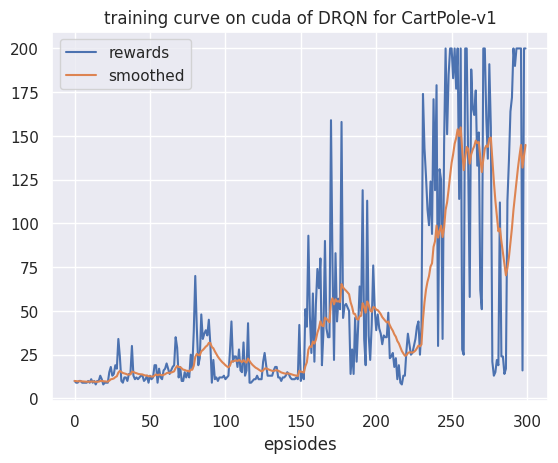

开始测试！
回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：200.00
回合：20/20，奖励：200.00
完成测试


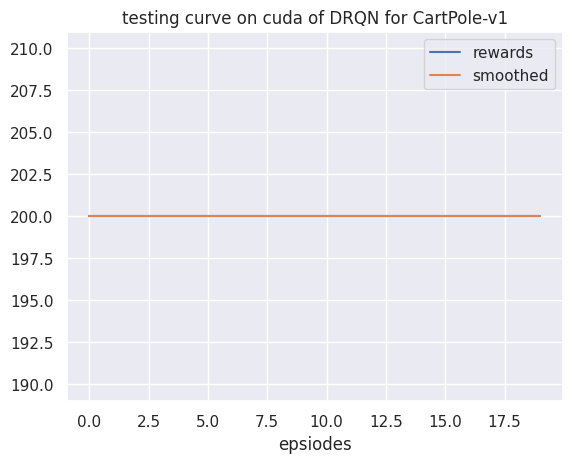

In [7]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果